In [252]:
import numpy as np
from keras.layers import Layer, Concatenate, Input, Dense
import keras.backend as K
from keras.models import load_model, Model
from keras.metrics import CategoricalAccuracy
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import custom_object_scope
from keras.losses import CategoricalCrossentropy

In [253]:
model_dir = 'model'
tanh_layer_size = 300
input_size = 1280
output_size = 2327
regions = 15

In [254]:
class QGAttention(Layer):
    def __init__(self, tanh_layer_size):
        super(QGAttention, self).__init__()
        self.tanh_layer_size = tanh_layer_size
 
    def build(self,input_shape):
        self.W1 = self.add_weight(name='attention_weight', shape=(input_shape[2], self.tanh_layer_size), 
                               initializer='random_normal', trainable=True)
        self.W2 = self.add_weight(name='attention_weight2', shape=(self.tanh_layer_size, 1), 
                               initializer='random_normal', trainable=True)
        #self.b=self.add_weight(name='attention_bias', shape=(1, 32), 
        #                       initializer='zeros', trainable=True)        
        super(QGAttention, self).build(input_shape)
 
    def get_config(self):
        config = super().get_config()
        config.update({
            "tanh_layer_size": self.tanh_layer_size,
        })
        return config
    
    # x = [batch_size, vector_length, regions]
    def call(self,x):
        #tanh layer
        e = K.tanh(K.dot(x, self.W1))
        #linear layer
        #print('e: ', e)
        e = K.dot(e, self.W2)
        #print('e: ', e)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        #print('e: ', e)
        # Compute the weights
        alpha = K.softmax(e)
        #print('alpha: ', alpha)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        #print('alpha: ', alpha)
        # Compute the context vector
        context = x * alpha
        #print('context: ', context)
        context = K.sum(context, axis=1)
        #print('context: ', context)
        return context

In [255]:
def get_model(regions, vector_input_size, tanh_layer_size):
    inputs = Input(shape=(regions, vector_input_size))
    inputs2 = QGAttention(tanh_layer_size)(inputs)
    outputs = Dense(output_size)(inputs2)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer="adam", 
        loss=CategoricalCrossentropy(
            from_logits=False,
            label_smoothing=0.0,
            axis=-0,
            reduction="auto",
            name="categorical_crossentropy",
        ),
        metrics=[CategoricalAccuracy()]
    )
    return model

In [270]:
def train(x, y):
    model = get_model(regions, input_size, tanh_layer_size)
    print(model.summary())
    
    es = EarlyStopping(monitor='val_categorical_accuracy', 
                       mode='max', 
#                        min_delta=0.5, 
                       patience=50)
    mc = ModelCheckpoint('model/best_model.h5', 
                         monitor='val_categorical_accuracy', 
                         mode='max', 
                         save_best_only=True,
                         save_weights_only=True)
    
    history = model.fit(x, y, 
                        verbose=2, 
                        validation_split=0.1, 
                        epochs=1000, 
                        callbacks=[es, mc])
    
    model.load_weights('model/best_model.h5')
    
    old_model = load_model(model_dir)
    _, old_acc = evaluate(x, y)
    _, new_acc = evaluate(x, y)
    if new_acc > old_acc:
        model.save(model_dir)
    return history

In [271]:
def predict(x):
    model = load_model(model_dir)
    print(model.predict(x))

In [272]:
def evaluate(x, y):
    model = load_model(model_dir)
    return model.evaluate(x, y)

In [273]:
def concat(question_str, regions_str):
    question = str2fv(question_str)
    regs = str2fvs(regions_str)
    result = []
    regs_count = len(regs)
    for i in range(0, regions):
        if i >= regs_count-1:
            result.append([0]*1280)
            continue
        reg = regs[i]
        reg.extend(question)
        result.append(reg)
    return result
    
def str2fvs(string):
    fvs = []
    for strfv in string.split('#'):
        fv = []
        for v in strfv.split('|'):
            fv.append(float(v))
        fvs.append(fv)
    return fvs

def str2fv(string):
    fv = []
    for v in string.split('|'):
        fv.append(float(v))
    return fv

In [274]:
df = pd.read_csv('data/train.csv')
df.head()

,question,id,img_regions,answer_type,0.1,00 310 539,1,1 08 11,1 3,1 4 ounce,...,yes green grey,yes grey shirt,yes no,yes on,yes white,yes yes,yogurt,yoplait,yorkie,zipper
0,-0.2378118336200714|0.343080997467041|-0.21145...,1616,0.4848161041736603|0.8302670121192932|0.333211...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.06691977381706238|0.34440624713897705|-0.22...,11910,0.5611845254898071|0.39622652530670166|0.21795...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.11341997981071472|0.2821967899799347|-0.144...,13392,0.9789563417434692|0.17534661293029785|0.13067...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.10996074229478836|0.4101363718509674|-0.159...,7274,1.396734595298767|0.0643806904554367|0.0101861...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.10682886093854904|0.34835386276245117|-0.120...,15488,0.34761351346969604|1.1078996658325195|0.77606...,other,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [275]:
x = []
y = []
for row in df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    x.append(concat(question, img_regions))
    y.append(answer)

X = tf.convert_to_tensor(x)
Y = tf.convert_to_tensor(y)

history = train(X, Y)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 15, 1280)]        0         
                                                                 
 qg_attention_22 (QGAttentio  (None, 1280)             384300    
 n)                                                              
                                                                 
 dense_22 (Dense)            (None, 2327)              2980887   
                                                                 
Total params: 3,365,187
Trainable params: 3,365,187
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
158/158 - 3s - loss: 0.2023 - categorical_accuracy: 0.0170 - val_loss: 0.1895 - val_categorical_accuracy: 0.0018 - 3s/epoch - 16ms/step
Epoch 2/1000
158/158 - 2s - loss: 0.1907 - categorical_accuracy: 0.0107 - val_loss: 0.1772 -

Epoch 50/1000
158/158 - 2s - loss: 0.1644 - categorical_accuracy: 0.0018 - val_loss: 0.1611 - val_categorical_accuracy: 0.0018 - 2s/epoch - 14ms/step
Epoch 51/1000
158/158 - 2s - loss: 0.1626 - categorical_accuracy: 0.0018 - val_loss: 0.1607 - val_categorical_accuracy: 0.0018 - 2s/epoch - 14ms/step
Epoch 52/1000
158/158 - 2s - loss: 0.1635 - categorical_accuracy: 0.0018 - val_loss: 0.1615 - val_categorical_accuracy: 0.0018 - 2s/epoch - 14ms/step
Epoch 53/1000
158/158 - 2s - loss: 0.1579 - categorical_accuracy: 0.0018 - val_loss: 0.1614 - val_categorical_accuracy: 0.0018 - 2s/epoch - 14ms/step
176/176 [==============================] - 1s 5ms/step - loss: 0.1497 - categorical_accuracy: 0.0969


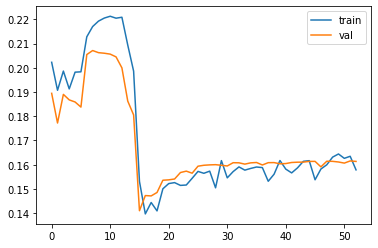

In [276]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

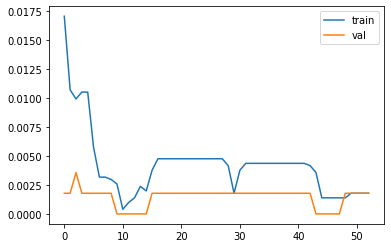

In [277]:
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [278]:
_, acc = evaluate(X, Y)
acc

176/176 [==============================] - 1s 5ms/step - loss: 0.1497 - categorical_accuracy: 0.0969


0.09690060466527939

In [279]:
test_df = pd.read_csv('data/test.csv')

## NUMBERS

In [280]:
number_df = test_df[test_df.answer_type == 'number']
print(number_df.shape[0])

tx = []
ty = []
for row in number_df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    tx.append(concat(question, img_regions))
    ty.append(answer)

tX = tf.convert_to_tensor(tx)
tY = tf.convert_to_tensor(ty)

evaluate(tX, tY)

5
1/1 [==============================] - 0s 61ms/step - loss: 0.0034 - categorical_accuracy: 0.2000


[0.003436154453083873, 0.20000000298023224]

## YES/NO

In [281]:
yesno_df = test_df[test_df.answer_type == 'yes/no']
print(yesno_df.shape[0])

tx = []
ty = []
for row in yesno_df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    tx.append(concat(question, img_regions))
    ty.append(answer)

tX = tf.convert_to_tensor(tx)
tY = tf.convert_to_tensor(ty)

evaluate(tX, tY)

49
2/2 [==============================] - 0s 5ms/step - loss: 0.0570 - categorical_accuracy: 0.0000e+00


[0.0569518618285656, 0.0]

## OTHER

In [282]:
other_df = test_df[test_df.answer_type == 'other']
print(other_df.shape[0])

tx = []
ty = []
for row in other_df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    tx.append(concat(question, img_regions))
    ty.append(answer)

tX = tf.convert_to_tensor(tx)
tY = tf.convert_to_tensor(ty)

evaluate(tX, tY)

568
18/18 [==============================] - 0s 5ms/step - loss: 0.0955 - categorical_accuracy: 0.0951


[0.0954810380935669, 0.09507042169570923]

## UNANSWERABLE

In [283]:
unanswerable_df = test_df[test_df.answer_type == 'unanswerable']
print(unanswerable_df.shape[0])

tx = []
ty = []
for row in unanswerable_df.values:
    question = row[0]
    img_regions = row[2]
    answer = row[4:]
    tx.append(concat(question, img_regions))
    ty.append(answer)

tX = tf.convert_to_tensor(tx)
tY = tf.convert_to_tensor(ty)

evaluate(tX, tY)

2
1/1 [==============================] - 0s 57ms/step - loss: nan - categorical_accuracy: 1.0000


[nan, 1.0]